In [96]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import sys, os
sys.path.append("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/")
os.chdir("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/")

from utils.distributions import Categorical

In [97]:
path = os.getcwd() + "/human-baseline-data/dataclips_vjnrfywhgilglbjxlzrrhptflpdn.json"

data = json.load(open(path))

high_risk_clicks = [8, 23, 38, 53]
goal_clicks = [15,30,45,60]
COST = 10
high_risk_click_reward = -1500 * 0.1
goal_reward = 50
meta_expected_scores = [65, 45, 60, 45, 60]
hierarchical_expected_scores =  [75, 55, -1460, 55, 70]

In [98]:
def get_expected_score(trialdata, COST=COST):
    path = trialdata["path"]
    queries = trialdata["queries"]["click"]["state"]["target"]
    # Replace first element with 0 for root
    ground_truth =  [0] + trialdata["stateRewards"][1:]
    reward = 0
    #print(path)
    #print(high_risk_clicks)
    for node in path:
        if node in queries or (int(node) in queries):
            reward += ground_truth[int(node)]
        else:
            if (node in high_risk_clicks) or (int(node) in high_risk_clicks):
                reward += high_risk_click_reward #Probability of triggering high risk event * negative reward of high risk event
            elif (node in goal_clicks) or (int(node) in goal_clicks):
                reward += goal_reward
            else:
                reward += 0 # Depends on experiment, in this case the expectation of all other nodes is 0
    # Click cost
    reward -= len(queries) * COST
    return reward

In [99]:
df_index = ["Participant", "Condition", "TrialId", "Score", "ExpectedScore", "NumClicks", "TestEnv", "HighRiskClicks"]
df_data = []

bonus_data = {}
known_workers = []
good_responses = 0
quiz_attempts = {}
demographics = []

# Parse raw mturk data into dataframe
for p_index, p_data in enumerate(data["values"]):
    # Filter out empty responses
    response_data = p_data[-1]
    if response_data != None:
        p_res_obj = json.loads(response_data)
        condition = p_res_obj["condition"]
        # Obfuscate worker ID for publishing
        worker = p_index #p_res_obj["workerId"] #
        if worker in known_workers:
            print("Duplicate worker", worker)
        else: 
            known_workers.append(worker)
        p_res = p_res_obj["data"]
        # Filter our incomplete trials
        # Get last instruction index
        # Test trials start after the last instruction
        # Index of that in the experiment is variable due to repeated instructions/quiz
        instruction_index = 0
        num_quiz = 0
        mouselab_seen = 0
        for i in range(len(p_res)):
            #print(p_res[i]["trialdata"]["trial_type"])
            if p_res[i]["trialdata"]["trial_type"] == "instructions":
                instruction_index = i+1
            if p_res[i]["trialdata"]["trial_type"] == 'survey-multi-choice':
                num_quiz += 1
        #print(instruction_index)
        if len(p_res) > instruction_index + 5 and (instruction_index>7):
            if(p_res[-2]["trialdata"]["trial_type"] == "survey-text"):
                try: 
                    demographics.append(p_res[-2]["trialdata"]["responses"])
                except:
                    pass
            quiz_attempts[worker] = num_quiz
            good_responses += 1
            for i in range(instruction_index,instruction_index+5):
                trial = p_res[i]
                trialdata = trial["trialdata"]
                assert trialdata["trial_type"] == "mouselab-mdp"
                trialid = trialdata["trial_id"]
                queries = trialdata["queries"]["click"]["state"]["target"]
                path = trialdata["path"]
                score = trialdata["score"]
                trial_id = int(trialdata["trial_id"])
                expected_score = get_expected_score(trialdata)
                num_risk_clicks = sum([1 for el in high_risk_clicks if str(el) in queries])
                df_data.append([worker, condition, trialid, score, expected_score, len(queries), trial_id, num_risk_clicks])
        else:
            pass
            #if instruction_index > 10:
            #   print([p_res[i]["trialdata"]["trial_type"] for i in range(len(p_res))])
        try:
            bonus_data[worker] = max(p_res_obj["questiondata"]["final_bonus"], 0.25)
        except:
            bonus_data[worker] = 0.25
            pass
            #print("Uncompleted but usable trial for worker", worker)

print("Good responses", good_responses)
df = pd.DataFrame(df_data, columns=df_index)

Good responses 48


In [100]:
# Study demographics

num_female = 0
age = 0
age_counter = 0
for x in demographics:
    p = json.loads(x)
    if p["Q2"].lower().strip() == "female" or p["Q2"].lower().strip() == "f":
        num_female += 1
    elif p["Q2"].lower().strip() == "male" or p["Q2"].lower().strip() == "m":
        pass
    else: 
        print("unrecognized gender", p["Q2"])
    if p["Q1"].isdigit():
        age += int(p["Q1"])
        age_counter += 1
    elif p["Q1"] == "20`":
        age += 20
        age_counter += 1
    else:
        print("Unrecognized age", p["Q1"])


print("Number of female participants", num_female)
print("Average age", age / age_counter)

Number of female participants 25
Average age 36.979166666666664


In [101]:
# Exclude participants with 0 clicks
participants = pd.DataFrame(df[df["NumClicks"] == 0].groupby("Participant").count()["NumClicks"])
excluded = list(participants[participants["NumClicks"]>2].index)
print("Exlcuded participants", excluded)
print("Total excluded", len(excluded))

Exlcuded participants [9, 16, 17, 18, 22, 23, 28, 29, 30, 31, 35, 37, 38, 39, 40, 53, 54, 57, 60, 62, 63, 64]
Total excluded 22


In [102]:
df_after_exclusion = df[~df["Participant"].isin(excluded)]
df_after_exclusion.to_csv(os.getcwd() + "/human-baseline-data/main_excluded.csv")
len(df_after_exclusion)

130

In [103]:
print("Total", len(df_after_exclusion["Participant"].unique()))

Total 26


In [104]:
print("Average bonus:", np.round(np.mean(list(bonus_data.values())),2))
print("Minimum bonus:", np.round(np.min(list(bonus_data.values())),2))
print("Maximum bonus:", np.round(np.max(list(bonus_data.values())),2))
print("Summed bonues", np.sum(list(bonus_data.values())))
print("\n")
for participant, bonus in bonus_data.items():
    if bonus > 0:
        print(f"{participant}, {bonus}")

Average bonus: 0.34
Minimum bonus: 0.25
Maximum bonus: 1.0
Summed bonues 18.209999999999997


0, 0.25
1, 0.25
2, 0.25
3, 0.25
8, 0.25
9, 0.25
10, 0.36
11, 0.25
13, 0.25
15, 0.25
16, 1
17, 0.25
18, 0.47
19, 0.25
20, 0.25
21, 0.25
22, 1
23, 0.25
24, 0.25
25, 0.25
26, 0.25
28, 0.25
29, 0.25
30, 1
31, 0.25
32, 0.25
33, 0.25
34, 0.25
35, 0.25
36, 0.25
37, 1
38, 0.25
39, 0.25
40, 0.25
42, 0.25
45, 0.25
46, 0.25
47, 0.25
48, 0.25
49, 0.25
50, 0.25
52, 0.25
53, 0.25
54, 0.25
56, 0.25
57, 0.25
58, 0.25
59, 0.25
60, 0.4
61, 0.25
62, 1
63, 0.98
64, 0.25


No demo -79.92307692307692 74.06074589713661


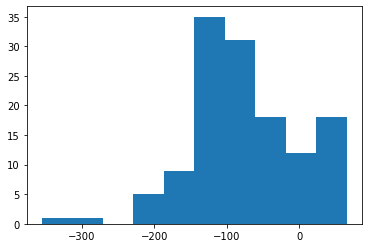

In [105]:
no_demo = df_after_exclusion[["ExpectedScore"]].to_numpy().flatten()

plt.hist(no_demo)
print("No demo", np.mean(no_demo), np.std(no_demo))

In [106]:
# Compare average participant score to the average score of our method on the same environments
no_demo = df_after_exclusion.groupby("Participant").mean()[["ExpectedScore"]].to_numpy().flatten()

print("No demo normal distribution test", stats.shapiro(no_demo))
checkVal = 41 # Meta controller performance on test trials, see pilot_creation.ipynb
# Check against 0 by subtracting the meta controller score

print("Significantly worse than metacontroller", stats.ttest_1samp(no_demo, checkVal))
print("Significantly worse than metacontroller", stats.wilcoxon(no_demo-checkVal))

No demo normal distribution test ShapiroResult(statistic=0.9566876888275146, pvalue=0.33056268095970154)
Significantly worse than metacontroller Ttest_1sampResult(statistic=-13.061939983301825, pvalue=1.1421835116408777e-12)
Significantly worse than metacontroller WilcoxonResult(statistic=0.0, pvalue=8.256460831710365e-06)
